# Load occupancy data: RC-60-Mix

In [1]:
import numpy as np 
import pandas as pd

In [2]:
root_folder = 'preprocessed_data_magazine/'
f_x = root_folder + '058_5p_to_1p_X.txt'
f_y = root_folder + '058_5p_to_1p_y.txt'
data = pd.read_csv(f_x, delimiter=' ', header = None)
labels = pd.read_csv(f_y, delimiter=' ', header = None)
print(data.shape, labels.shape)

(4340, 5976) (4340, 1)


In [3]:
labels.value_counts()
# label 1: 5p
# label 2: 4p
# label 3: 3p
# label 4: 2p
# label 5: 1p

1    902
3    902
4    902
2    852
5    782
dtype: int64

In [4]:
def count_HOV_LOV(labels):# HOV: label=1 ; LOV: label=2
    count_hov = 0
    count_lov = 0
    HOV_index = []
    LOV_index = []
    if len(labels.shape)==2:
        labels = np.squeeze(labels).tolist()
    for idx, l in enumerate(labels):
        if l==1:
            count_hov+=1
            HOV_index.append(idx)
        elif l==2:
            count_lov+=1
            LOV_index.append(idx)
        else:
            raise SystemExit("should have two unique labels in HOV_LOV problem!")
    print('HOV : {0}'.format(count_hov))
    print('LOV : {0}'.format(count_lov))
    return HOV_index, LOV_index
    

In [5]:
def transfer_to_HOV_LOV(labels):# HOV: label=1 ; LOV: label=2
    if len(labels.shape)==2:
        labels = np.squeeze(labels).tolist()
    for idx, l in enumerate(labels):
        if l == 1:#5people: HOV
            labels[idx]=1
        elif l==2:#4people: HOV
            labels[idx]=1
        elif l==3:#3people
            labels[idx]=1
        elif l==4:#2people
            labels[idx]=2
        elif l==5:
            labels[idx]=2
        else:
            raise SystemExit("invalid label")
    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=1)
    return labels

In [6]:
hov_lov_labels = transfer_to_HOV_LOV(labels)

In [7]:
_,_=count_HOV_LOV(hov_lov_labels)

HOV : 2656
LOV : 1684


# RC-60-Mix: extract subdata by each label and produce 2d data

In [8]:
from utils.sampling import extract_car_data, generate_2d_data, get_all_cars_2d

In [9]:
bin_length, stride = 6, 1
total_bin = None

In [10]:
unique_labels = [1, 2, 3, 4, 5]
aggregate_data, aggregate_label = get_all_cars_2d(data, labels, unique_labels, bin_length, stride, total_bin)

In [11]:
aggregate_data.shape, aggregate_label.shape

((4310, 6, 5976), (4310,))

# Transfer exact occupancy labels to HOV/LOV
* (1) LOV: 1 or 2 people => label = 2 
* (2) HOV: 3, 4, or 5 people => label = 1

In [12]:
new_aggregate_label = transfer_to_HOV_LOV(aggregate_label.copy())

In [13]:
min(new_aggregate_label), max(new_aggregate_label)

(array([1]), array([2]))

In [14]:
# after generating 2d data
hov_index, lov_index = count_HOV_LOV(new_aggregate_label)

HOV : 2638
LOV : 1672


In [15]:
# imbalance ratio
1672/(2638+1672)

0.38793503480278424

In [16]:
type(aggregate_data), type(new_aggregate_label)

(numpy.ndarray, numpy.ndarray)

# oversampling minority class

In [17]:
import random 
deficit = len(hov_index)-len(lov_index)
random.seed(10)
random_oversampling_index=random.sample(lov_index, k=deficit)


In [18]:
aggregate_data.shape, new_aggregate_label.shape

((4310, 6, 5976), (4310, 1))

In [19]:
random_lov_x = aggregate_data[random_oversampling_index]
random_lov_y = new_aggregate_label[random_oversampling_index]

In [20]:
oversampling_x = np.concatenate([aggregate_data,random_lov_x], axis=0)
oversampling_y = np.concatenate([new_aggregate_label,random_lov_y], axis=0)
print(oversampling_x.shape, oversampling_y.shape)

(5276, 6, 5976) (5276, 1)


In [21]:
_,_ = count_HOV_LOV(oversampling_y)

HOV : 2638
LOV : 2638


# Train 2d cnn on RC-60-Mix

In [22]:
from das_lib.models import cnn2d_dropout
from das_lib.funs import split_train_test_2d

2023-07-11 17:23:12.881380: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [23]:
from das_lib.funs import *
test_frac = .2
aggregate_data= np.expand_dims(aggregate_data,-1)
y_one_hot = tf.keras.utils.to_categorical(new_aggregate_label-1, num_classes=2)
x_train, x_test, y_train, y_test, training_index = split_train_test_2d(aggregate_data, y_one_hot, test_frac)
m = cnn2d_dropout( (x_train.shape[1], x_train.shape[2],1), y_train.shape[1])
print(m.summary())

2023-07-11 17:23:47.429511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 17:23:50.269638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 33345 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d8:00.0, compute capability: 8.0


Model: "1dcnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 5976, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 4, 5913, 16)       3088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 739, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 739, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 724, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 90, 32)        0         
 2D)                                                   

In [24]:
H = m.fit(x_train, y_train, epochs=500, batch_size=64, validation_data=(x_test, y_test), verbose=False)
m.evaluate(x_test, y_test, batch_size=64, verbose=True)

2023-07-11 17:26:01.033879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-07-11 17:26:07.562587: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 0s 14ms/step - loss: 0.0118 - accuracy: 0.9676


[0.011798837222158909, 0.967555046081543]

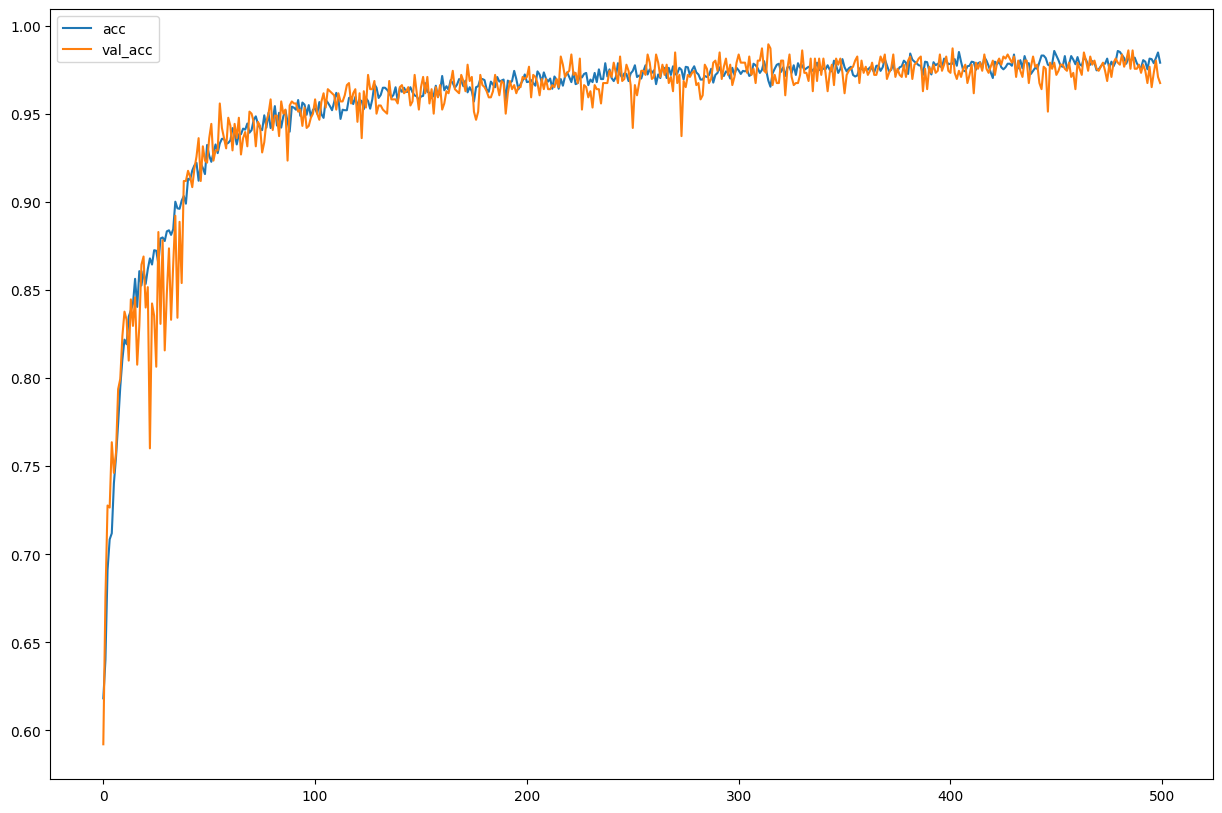

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.plot(H.history['accuracy'], label='acc')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.legend()

In [26]:
checkpoint_folder = 'training_results'
model_name = '2way_2d_plus'
checkpoint_path = checkpoint_folder+'/'+'{0}'.format(model_name)
m.save(checkpoint_path)

INFO:tensorflow:Assets written to: training_results/2way_2d_plus/assets


INFO:tensorflow:Assets written to: training_results/2way_2d_plus/assets


In [27]:
from das_lib.evaluation import save_training_history
f_name = 'performance/2way_2d_plus.json'
save_training_history(f_name, H)

# Read the trained model

In [28]:
import tensorflow as tf
checkpoint_folder = 'training_results'
model_name = '2way_2d_plus'
checkpoint_path = checkpoint_folder+'/'+'{0}'.format(model_name)
m = tf.keras.models.load_model(checkpoint_path)

# Validate the trained model on Ind. RC-60-1p

In [29]:
from utils.sampling import extract_car_data, generate_2d_data
root_folder = '../DAS_magazine/preprocessed_data/'
f_x = root_folder+'non_SD_datax026.txt' 
f_y = root_folder+'datay026.txt'
car_label = 2 # in speed data (023-027), car 2 is label = 2
car2_data =  extract_car_data(f_x, f_y, car_label)

In [30]:
bin_length, stride, total_bin = 6, 1, None
car2_1p_data, car2_1p_label_old = generate_2d_data(car2_data, car_label, bin_length, stride, total_bin)

In [31]:
def expand_data(data, label, num_classes):
    data= np.expand_dims(data,-1)
    label = np.array([label]*len(data))
    label = tf.keras.utils.to_categorical(label-1, num_classes)
    return data, label

In [32]:
label = 2 # in terms of occupancy, we have 1p driving car 2 => label = 2
num_classes = 2
car2_1p_data, car2_1p_label_new = expand_data(car2_1p_data, label, num_classes)

In [33]:
m.evaluate(car2_1p_data, car2_1p_label_new)

14/14 [==============================] - 0s 9ms/step - loss: 0.2136 - accuracy: 0.5169


[0.2136208713054657, 0.516853928565979]

In [34]:
from das_lib.evaluation import save_wrong_indices
f_name = 'performance/wrong_indices/2way_2d_1p_plus.json'
save_wrong_indices(f_name, m, car2_1p_data, car2_1p_label_new)

14/14 [==============================] - 0s 4ms/step


# Validate the trained mode on Ind. RC-60-5p

In [35]:
root_folder = '../DAS_magazine/preprocessed_data_magazine/'
f_x = root_folder+'058_5p_X.txt' 
f_y = root_folder+'058_5p_y.txt'
car_label = 1 #old label, direction west => label=1
car2_5p_data = extract_car_data(f_x, f_y, car_label)
car2_5p_data, car2_5p_label_old = generate_2d_data(car2_5p_data, car_label, bin_length, stride, total_bin)

In [36]:
label = 1 #new label, 5p in car 2 = > label = 1 
num_classes = 2
car2_5p_data, car2_5p_label_new = expand_data(car2_5p_data, label, num_classes)

In [37]:
car2_5p_data.shape, car2_5p_label_new.shape

((285, 6, 5976, 1), (285, 2))

In [38]:
m.evaluate(car2_5p_data, car2_5p_label_new)

9/9 [==============================] - 0s 6ms/step - loss: 0.2360 - accuracy: 0.5298


[0.23595936596393585, 0.5298245549201965]

In [39]:
f_name = 'performance/wrong_indices/2way_2d_5p_plus.json'
save_wrong_indices(f_name, m, car2_5p_data, car2_5p_label_new)

9/9 [==============================] - 0s 4ms/step
